# Book Data Audit

This notebook audits for significant changes in the clustering results in the book data, to allow us to detect the significance of shifts from version to version.  It depends on the aligned cluster identities in `isbn-version-clusters.parquet`.

Data versions are indexed by month; versions corresponding to tagged versions also have the version in their name.

We are particularly intersted in the shift in *number* of clusters, and shifts in which cluster an ISBN is associated with (while cluster IDs are not stable across versions, this notebook works on an aligned version of the cluster-ISBN associations).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

Define the versions we care about:

In [2]:
versions = ['pgsql', '2022-03-2.0', '2022-07', '2022-10', '2022-11-2.1', 'current']

Load the aligned ISBNs:

In [3]:
isbn_clusters = pd.read_parquet('isbn-version-clusters.parquet')
isbn_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33538726 entries, 0 to 33538725
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   isbn         object 
 1   isbn_id      int32  
 2   current      float64
 3   2022-11-2.1  float64
 4   2022-10      float64
 5   2022-07      float64
 6   2022-03-2.0  float64
 7   pgsql        float64
dtypes: float64(6), int32(1), object(1)
memory usage: 1.9+ GB


## Cluster Counts

Let's look at the # of ISBNs and clusters in each dataset:

In [4]:
metrics = isbn_clusters[versions].agg(['count', 'nunique']).T.rename(columns={
    'count': 'n_isbns',
    'nunique': 'n_clusters',
})
metrics

,n_isbns,n_clusters
pgsql,24482342,13213677
2022-03-2.0,24503563,13201869
2022-07,32715079,17078096
2022-10,32715078,16882949
2022-11-2.1,33505211,17673075
current,33505211,17673075


## Cluster Size Distributions

Now we're going to look at how the sizes of clusters, and the distribution of cluster sizes and changes.

In [5]:
sizes = dict((v, isbn_clusters[v].value_counts()) for v in versions)
sizes = pd.concat(sizes, names=['version', 'cluster'])
sizes.name = 'size'
sizes

version  cluster    
pgsql    100026918.0    7818
         102066477.0    7520
         101187720.0    6518
         107931428.0    4276
         100073294.0    3712
                        ... 
current  108968958.0       1
         108443078.0       1
         933456998.0       1
         114266232.0       1
         414665017.0       1
Name: size, Length: 95722741, dtype: int64

Compute the histogram:

In [6]:
size_hist = sizes.groupby('version').value_counts()
size_hist.name = 'count'
size_hist

version      size
2022-03-2.0  2       6256782
             1       5807972
             4        551072
             3        268793
             6         96525
                      ...   
pgsql        3712          1
             4276          1
             6518          1
             7520          1
             7818          1
Name: count, Length: 2608, dtype: int64

And plot the cumulative distributions:

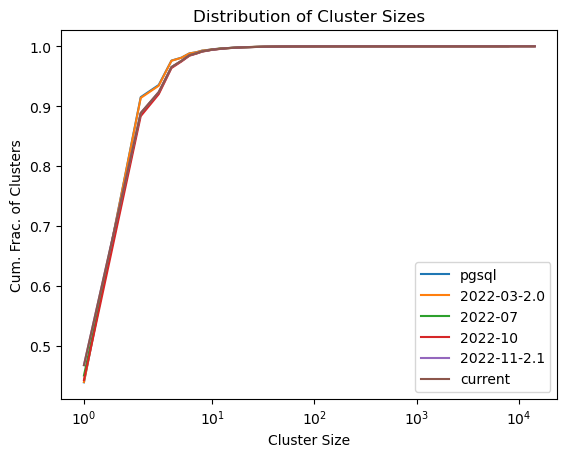

In [7]:
for v in versions:
    vss = size_hist.loc[v].sort_index()
    vsc = vss.cumsum() / vss.sum()
    plt.plot(vsc.index, vsc.values, label=v)

plt.title('Distribution of Cluster Sizes')
plt.ylabel('Cum. Frac. of Clusters')
plt.xlabel('Cluster Size')
plt.xscale('symlog')
plt.legend()
plt.show()

Save more metrics:

In [8]:
metrics['max_size'] = pd.Series({
    v: sizes[v].max()
    for v in versions
})
metrics

,n_isbns,n_clusters,max_size
pgsql,24482342,13213677,7818
2022-03-2.0,24503563,13201869,7976
2022-07,32715079,17078096,13988
2022-10,32715078,16882949,14378
2022-11-2.1,33505211,17673075,14378
current,33505211,17673075,14378


## Different Clusters

### ISBN Changes

How many ISBNs changed cluster across each version?

In [9]:
statuses = ['same', 'added', 'changed', 'dropped']
changed = isbn_clusters[['isbn_id']].copy(deep=False)
for (v1, v2) in zip(versions, versions[1:]):
    v1c = isbn_clusters[v1]
    v2c = isbn_clusters[v2]
    cc = pd.Series('same', index=changed.index)
    cc = cc.astype('category').cat.set_categories(statuses, ordered=True)
    cc[v1c.isnull() & v2c.notnull()] = 'added'
    cc[v1c.notnull() & v2c.isnull()] = 'dropped'
    cc[v1c.notnull() & v2c.notnull() & (v1c != v2c)] = 'changed'
    changed[v2] = cc
    del cc
changed.set_index('isbn_id', inplace=True)
changed.head()

,2022-03-2.0,2022-07,2022-10,2022-11-2.1,current
isbn_id,,,,,
15581631,same,same,same,same,same
27473311,same,same,same,same,same
5015075,same,same,same,same,same
20328197,same,added,same,same,same
22877688,same,same,same,same,same


Count number in each trajectory:

In [10]:
trajectories = changed.value_counts()
trajectories = trajectories.to_frame('count')
trajectories['fraction'] = trajectories['count'] / len(changed)
trajectories['cum_frac'] = trajectories['fraction'].cumsum()

In [11]:
trajectories

count      fraction  \
2022-03-2.0 2022-07 2022-10 2022-11-2.1 current                           
same        same    same    same        same     23940905  7.138287e-01   
            added   same    same        same      8178697  2.438583e-01   
            same    same    added       same       789591  2.354267e-02   
            changed same    same        same       224605  6.696885e-03   
            same    changed same        same       194933  5.812177e-03   
added       same    same    same        same        86414  2.576544e-03   
changed     same    same    same        same        42770  1.275242e-03   
dropped     added   same    same        same        41966  1.251270e-03   
            same    same    same        same        24300  7.245356e-04   
same        dropped same    same        same         9038  2.694795e-04   
changed     changed same    same        same         2885  8.601996e-05   
added       changed same    same        same         1461  4.356158e-05   
dropped     same    same    added       same          599  1.785995e-05   
changed     same    changed same        same          258  7.692600e-06   
added       same    same    dropped     same           93  2.772914e-06   
                    changed same        same           60  1.788977e-06   
            dropped same    same        same           52  1.550446e-06   
same        dropped same    added       same           52  1.550446e-06   
changed     dropped same    same        same           13  3.876116e-07   
same        same    same    changed     same            6  1.788977e-07   
            added   same    dropped     same            5  1.490814e-07   
changed     same    same    dropped     same            5  1.490814e-07   
same        added   changed same        same            5  1.490814e-07   
added       changed same    dropped     same            4  1.192651e-07   
same        same    same    dropped     same            3  8.944884e-08   
added       same    dropped same        same            1  2.981628e-08   
            dropped same    added       same            1  2.981628e-08   
same        same    changed changed     same            1  2.981628e-08   
changed     changed same    dropped     same            1  2.981628e-08   
            dropped same    added       same            1  2.981628e-08   
same        changed changed same        same            1  2.981628e-08   

                                                 cum_frac  
2022-03-2.0 2022-07 2022-10 2022-11-2.1 current            
same        same    same    same        same     0.713829  
            added   same    same        same     0.957687  
            same    same    added       same     0.981230  
            changed same    same        same     0.987927  
            same    changed same        same     0.993739  
added       same    same    same        same     0.996315  
changed     same    same    same        same     0.997591  
dropped     added   same    same        same     0.998842  
            same    same    same        same     0.999566  
same        dropped same    same        same     0.999836  
changed     changed same    same        same     0.999922  
added       changed same    same        same     0.999965  
dropped     same    same    added       same     0.999983  
changed     same    changed same        same     0.999991  
added       same    same    dropped     same     0.999994  
                    changed same        same     0.999995  
            dropped same    same        same     0.999997  
same        dropped same    added       same     0.999999  
changed     dropped same    same        same     0.999999  
same        same    same    changed     same     0.999999  
            added   same    dropped     same     0.999999  
changed     same    same    dropped     same     0.999999  
same        added   changed same        same     1.000000  
added       changed same    dropped     same     1.000000  
same        same

In [12]:
metrics['new_isbns'] = (changed[versions[1:]] == 'added').sum().reindex(metrics.index)
metrics['dropped_isbns'] = (changed[versions[1:]] == 'dropped').sum().reindex(metrics.index)
metrics['changed_isbns'] = (changed[versions[1:]] == 'changed').sum().reindex(metrics.index)
metrics

,n_isbns,n_clusters,max_size,new_isbns,dropped_isbns,changed_isbns
pgsql,24482342,13213677,7818,NaN,NaN,NaN
2022-03-2.0,24503563,13201869,7976,88086.0,66865.0,45933.0
2022-07,32715079,17078096,13988,8220673.0,9157.0,228957.0
2022-10,32715078,16882949,14378,0.0,1.0,195258.0
2022-11-2.1,33505211,17673075,14378,790244.0,111.0,7.0
current,33505211,17673075,14378,0.0,0.0,0.0


The biggest change is that the July 2022 update introduced a large number (8.2M) of new ISBNs.  This update incorporated more current book data, and changed the ISBN parsing logic, so it is not surprising.

Let's save these book changes to a file for future re-analysis:

In [13]:
changed.to_parquet('isbn-cluster-changes.parquet', compression='zstd')

## Final Saved Metrics

Now we're going to save this metric file to a CSV.

In [14]:
metrics.index.name = 'version'
metrics

,n_isbns,n_clusters,max_size,new_isbns,dropped_isbns,changed_isbns
version,,,,,,
pgsql,24482342,13213677,7818,NaN,NaN,NaN
2022-03-2.0,24503563,13201869,7976,88086.0,66865.0,45933.0
2022-07,32715079,17078096,13988,8220673.0,9157.0,228957.0
2022-10,32715078,16882949,14378,0.0,1.0,195258.0
2022-11-2.1,33505211,17673075,14378,790244.0,111.0,7.0
current,33505211,17673075,14378,0.0,0.0,0.0


In [15]:
metrics.to_csv('audit-metrics.csv')